# 2d Mouse Erythroid

This notebook runs mouse erythroid experiments in 2d case

This dataset shows mouse gastrulation subset to erythroid lineage, representing the developmental pathway during which embryonic cells diversify into lineage-specific precursors, evolving into adult organisms. The data consists of 9,815 cells evolving through five lineage stages as shown in [cell data notebook](cell_data.ipynb).

In this notebook we implement OT-CFM and Curly-FM and we show learnt trajectories using both methods.

Mouse erythroid cells follow a curved developmental trajectory over time. We show that Curly-FM can recover these trajectories using RNA velocity priors

In [6]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
import anndata as ad
import pandas as pd
import scvelo as scv
import torch

from torchcfm import optimal_transport
from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# set seed
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# load Cell data
adata = sc.read_h5ad("../data/Erythroid/cells.h5ad") 

In [10]:
num_times = 3
k=30
latent = adata.obs["latent_time"].to_numpy(float)
edges = np.quantile(latent, np.linspace(0, 1, num_times + 1))
bin_id = np.digitize(latent, edges[1:-1], right=False)
adata.obs["stage3"] = pd.Categorical(bin_id, categories=[0, 1, 2], ordered=True) 
coords = adata.obsm["X_umap"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_umap_standardized"] = coords
positions = [
    adata.obsm["X_umap_standardized"][adata.obs["stage3"].cat.codes == k]
    for k in range(num_times)
]
velocities = [
    adata.obsm["velocity_umap"][adata.obs["stage3"].cat.codes == k]
    for k in range(num_times)
]

In [11]:
train_ts = [0, 2]
test_ts = [1]

x_train, v_train = [], []
x_test, v_test = [], []

for t in range(num_times):
    if t in train_ts:
        x_train.append(positions[t])
        v_train.append(velocities[t])
    elif t in test_ts:
        x_test.append(positions[t])
        v_test.append(velocities[t])
        
x_train = np.stack(x_train)
v_train = np.stack(v_train)
x_test = np.stack(x_test)
v_test = np.stack(v_test)

print(x_train.shape, v_train.shape)
print(x_test.shape, v_test.shape)

(2, 3272, 2) (2, 3272, 2)
(1, 3271, 2) (1, 3271, 2)


In [12]:
import seaborn as sns 
stages = adata.obs["stage3"]                    
palette = sns.color_palette("husl", stages.nunique())
lut     = {str(k): v for k, v in zip(stages.cat.categories, palette)}

colours = stages.astype(str).map(lut).to_numpy()

def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.scatter(
        adata.obsm["X_umap_standardized"][:, 0],
        adata.obsm["X_umap_standardized"][:, 1],
        c=colours,
        s=4,
        alpha=1,
    )

    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.05, c="olive")
    variable_h = len(traj) // 2
    ax.scatter(traj[variable_h, :n, 0], traj[variable_h, :n, 1], s=4, alpha=1, c="orange")
    ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])


In [13]:
def get_ut_knn_gaussian(
    xt: torch.Tensor,  
    x0: torch.Tensor, 
    x1: torch.Tensor,  
    v0: torch.Tensor, 
    v1: torch.Tensor, 
    k: int = 100,
    eps: float = 1e-12,
):
    x = torch.cat([x0, x1], dim=0)
    v = torch.cat([v0, v1], dim=0)

    dists = torch.cdist(xt, x)

    knn_dists, knn_idx = torch.topk(dists, k=k, dim=1, largest=False)

    h = knn_dists[:, -1:].clamp_min(eps)  
    w = torch.exp(-(knn_dists**2) / (2 * h**2))  
    w = w / (w.sum(dim=1, keepdim=True) + eps)  

    v_knn = v[knn_idx]  
    v_xt = (w.unsqueeze(-1) * v_knn).sum(dim=1) * 100

    distance_factor = knn_dists[:, :1]
    w = 100
    dist_thresh = 0.2
    distance_factor = (torch.nn.functional.sigmoid((distance_factor - dist_thresh) * w) / 2) + 0.5
    noise_vector = torch.randn_like(v_xt) * 0.01
    v_xt = (1 - distance_factor) * v_xt + distance_factor * noise_vector

    return v_xt, knn_dists

In [14]:
def get_batch(FM_module, X, batch_size, n_times, ts_train, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(len(ts_train) - 1):
            
        t_end = t_start + 1
        
        x0 = (
            torch.from_numpy(
                X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )    
        x1 = (
            torch.from_numpy(
                X[t_end][np.random.randint(X[t_end].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        
        if return_noise:
            t, xt, ut, eps = FM_module.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM_module.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        
    t = torch.cat(ts)

    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut


In [15]:
import torch.nn.functional as F

class CurlyWrapperWithMetrics(torch.nn.Module):
    def __init__(self, model, x0, x1, v0, v1, k):
        super().__init__()
        self.model = model
        self.x0 = x0
        self.x1 = x1
        self.v0 = v0
        self.v1 = v1
        self.k = k

    def forward(self, t, z, *args, **kwargs):
        x = z[:, :-2]
        x_dot = self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], dim=1))

        u_t, _ = get_ut_knn_gaussian(
            x,
            self.x0,
            self.x1,
            self.v0,
            self.v1,
            k=self.k,
        )

        cos_dist = 1 - F.cosine_similarity(u_t, x_dot, dim=1)
        L2_squared = torch.sum((u_t - x_dot) ** 2, dim=1)

        return torch.cat([x_dot, cos_dist.unsqueeze(1), L2_squared.unsqueeze(1)], dim=1)


## OT-CFM

In [16]:
batch_size = 256
sigma = 0.01
dim = 2
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
print(k, num_times)


30 3


100%|██████████| 3000/3000 [00:25<00:00, 117.10it/s]


Text(0, 0.5, 'Loss')

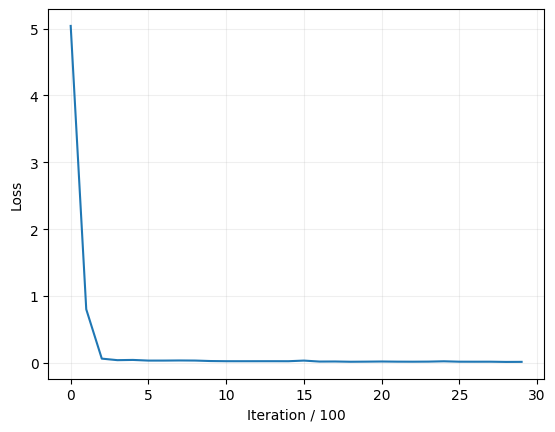

In [17]:
loss_otcfm = []

start_time = time.time()

for i in tqdm(range(3000)):
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, x_train, batch_size, num_times, train_ts)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()

    if i % 100 == 0:
        loss_otcfm.append(loss.cpu().item())
        
end_time = time.time()

train_time_ot_cfm = end_time - start_time

plt.plot(loss_otcfm)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")


tensor(2.7265)
Avg Cosine distance:  0.14575043
Avg L2 cost:  2.7265215
Avg Wass-2 distance:  0.6375115653252813

----------------------

t            Cosine-dist    &      L2 cost       &       Wass-2 
t2 --- 0.14575043320655823 & 2.7265214920043945 & 0.6375115653252813 \\

OT-CFM training time -- 0:25 (mins:secs)


<Figure size 500x400 with 0 Axes>

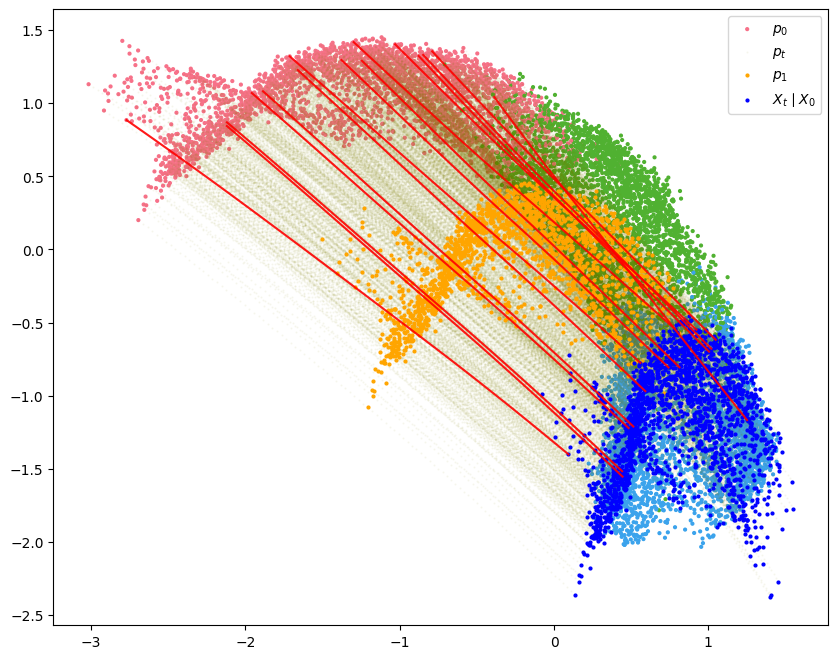

In [18]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)
        v0 = torch.from_numpy(v_train[t]).float().to(device)
        v1 = torch.from_numpy(v_train[t + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(ot_cfm_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        out = node.trajectory(
            z0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        traj_tmp = out[:, :, :-2]

        trajs.append(traj_tmp)

    traj_ot_cfm = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1, cos_dist, L2_cost = [], [], []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)
        v0 = torch.from_numpy(velocities[t_train]).float().to(device)
        v1 = torch.from_numpy(velocities[t_train + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(ot_cfm_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        pred_out = node.trajectory(
            z0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred_traj = pred_out[:, :, :-2]
        cosine_traj = pred_out[:, :, -2]
        L2_traj = pred_out[:, :, -1]

        pred = pred_traj[-1]

        cos_dist.append(cosine_traj[-1].cpu().mean())
        L2_cost.append(L2_traj[-1].cpu().mean())

        print(L2_traj[-1].cpu().mean())

        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    cos_dist = np.stack(cos_dist)
    L2_cost = np.stack(L2_cost)

    print("Avg Cosine distance: ", np.mean(cos_dist))
    print("Avg L2 cost: ", np.mean(L2_cost))

    wass1 = np.stack(wass1)
    print("Avg Wass-2 distance: ", np.mean(wass1))
    
    print()
    print("----------------------")
    print()
    print("t            Cosine-dist    &      L2 cost       &       Wass-2 ")
    for i, t_left_out in enumerate(["t2"]):   # , "t4", "t6", "t8"
        print(
            t_left_out + f" --- {cos_dist[i]} & {L2_cost[i]} & {wass1[i]} \\\\"
        )
    
    minutes = int(train_time_ot_cfm // 60)
    seconds = int(train_time_ot_cfm % 60)

    print()
    print(f"OT-CFM training time -- {minutes}:{seconds} (mins:secs)")

    plot_trajectories(
        traj_ot_cfm.cpu().numpy()
    )


## Curly

In [19]:
from torch.func import vmap
import scipy

def get_xt(t, t_start, x0, x1, geodesic_model, sigma=0.0):
    mu_t = (1 - t) * x0 + t * x1 +  t * (1-t) * (geodesic_model(torch.cat([x0, x1, t+t_start], dim=-1)))
    epsilon = torch.randn_like(x0)
    x_t = mu_t + torch.sqrt(t*(1-t))*sigma * epsilon
    return mu_t, x_t, epsilon

def get_xt_xt_dot(t, t_start, t_end, x0, x1, geodesic_model, sigma=0.0):
    with torch.enable_grad():
        t = t[..., None]
        t.requires_grad_(True)
        mu_t, xt, eps = get_xt(t, t_start, x0, x1, geodesic_model, sigma=sigma)
        mu_t_dot_list = []
        for i in range(xt.shape[-1]):
            mu_t_dot_list.append(
                torch.autograd.grad(torch.sum(mu_t[..., i]), t, create_graph=True)[0]
            )
        mu_t_dot = torch.cat(mu_t_dot_list, -1)
    return xt, mu_t_dot, eps

def coupling(
    t_start, t_end, x0, x1, x0s, x1s, v0s, v1s, geodesic_model, k, sigma
):
    batch_size, d = x0.shape
    t = torch.rand(1).type_as(x0) * torch.ones((batch_size, batch_size), device=x0.device)
    x0_r = x0.repeat(batch_size, 1, 1)
    x1_r = x1.repeat(batch_size, 1, 1).transpose(0, 1)

    xt, mu_t_dot, eps = get_xt_xt_dot(
        t, t_start, t_end, x0_r, x1_r, geodesic_model, sigma
    )

    ut = vmap(lambda x: get_ut_knn_gaussian(x, x0s, x1s, v0s, v1s, k=k)[0], randomness="different")(xt)

    L2_cost = 0.5 * ((mu_t_dot.detach() - ut) ** 2).sum(-1)
    _, j = scipy.optimize.linear_sum_assignment(L2_cost.detach().cpu().numpy())

    pi_x0 = x0[j]
    pi_x1 = x1

    return pi_x0, pi_x1, eps


In [20]:
def get_batch_geo(geo, X, V, batch_size, sigma, ts_train):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    uts = []
    dists = []
    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1
        
        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)

        v0 = torch.from_numpy(V[t_start][idcs_0]).float().to(device)
        v1 = torch.from_numpy(V[t_end][idcs_1]).float().to(device)
    
        t = torch.rand(x0.shape[0]).type_as(x0) 
        t_o = t
        
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)
        ut, dist = get_ut_knn_gaussian(
            xt,
            x0,
            x1,
            v0,
            v1,
            k=k,
        )
        xt = xt + torch.sqrt(t* (1-t)).unsqueeze(1) * sigma * eps
        
        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)
        dists.append(dist)
    
    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)
    dist = torch.cat(dists)

    return t_orig, t, xt, ut, mu_t_dot, eps, dist


In [21]:
batch_size = 256
sigma = 0.01
alpha = 0.1
dim = 2

100%|██████████| 2000/2000 [00:16<00:00, 122.14it/s]


Text(0, 0.5, 'Loss')

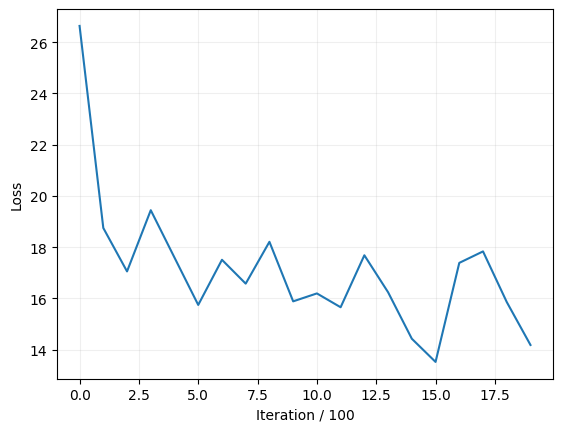

In [22]:
geo_model = MLP(dim=4, out_dim=dim, time_varying=True, w=64).to(device)
geo_optimizer = torch.optim.AdamW(geo_model.parameters(), 1e-4)

train_loss = []

start_time = time.time()

for i in tqdm(range(2_000)):
    geo_optimizer.zero_grad()
    t_orig, t, xt, ut, mu_t_dot, eps, knn_dist = get_batch_geo(geo_model, x_train, v_train, batch_size, sigma, train_ts)
 
    hinge_value = 0.1
    knn_dist[knn_dist < hinge_value] = hinge_value
    knn_loss = torch.mean(knn_dist)

    cosine_loss = 1 - torch.nn.functional.cosine_similarity(ut, mu_t_dot).mean()
    loss = 1 * torch.mean((alpha*ut - mu_t_dot) ** 2) + 50*cosine_loss + 0 * knn_loss
    
    loss.backward()
    geo_optimizer.step()

    if i % 100 == 0:
        train_loss.append(loss.cpu().item())

end_time = time.time()

train_time_curly_geo = end_time - start_time

plt.plot(train_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")

In [23]:
def get_batch_vel(geo, X, V, batch_size, sigma, ts_train):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1

        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)

        v0 = torch.from_numpy(V[t_start][idcs_0]).float().to(device)
        v1 = torch.from_numpy(V[t_end][idcs_1]).float().to(device)

        t = torch.rand(x0.shape[0]).type_as(x0)
        t_o = t

        x0, x1, _ = coupling(t_start, t_end, x0, x1, x0, x1, v0, v1, geo, k, sigma=sigma)
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)

        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)

    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)

    return t_orig, t, xt, mu_t_dot, eps


In [24]:
batch_size = 256
sigma = 0.01
alpha = 1.0
dim = 2
vel_model = MLP(dim=dim, time_varying=True, w=64).to(device).to(device)
vel_optimizer = torch.optim.Adam(vel_model.parameters(), 1e-4)

100%|██████████| 3000/3000 [03:27<00:00, 14.43it/s]


Text(0.5, 0, 'Iteration / 100')

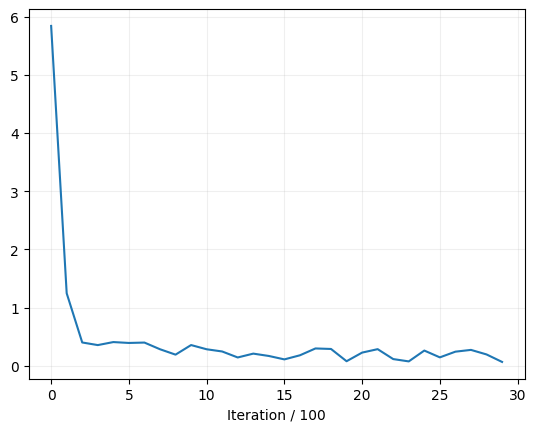

In [25]:
vel_loss = []

start_time = time.time()

for i in tqdm(range(3000)):
    vel_optimizer.zero_grad()
    
    t_orig, t, xt, mu_t_dot, eps = get_batch_vel(geo_model, x_train, v_train, batch_size, sigma, train_ts)
    vt = vel_model(torch.cat([xt.detach(), t[:, None]], dim=-1))
    
    loss = torch.mean((vt - mu_t_dot.detach()) ** 2)

    loss.backward() 
    vel_optimizer.step()

    if i % 100 == 0:
        vel_loss.append(loss.cpu().item())


end_time = time.time()

train_time_curly_vel = end_time - start_time

plt.plot(vel_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")

tensor(1.0291)
Avg Cosine distance:  0.013113144
Avg L2 cost:  1.0291095
Avg Wass-2 distance:  0.6454878533426266

----------------------

t            Cosine-dist    &      L2 cost       &       Wass-2 
t2 --- 0.013113143853843212 & 1.0291094779968262 & 0.6454878533426266 \\

Curly training time -- 3:44 (mins:secs)


<Figure size 500x400 with 0 Axes>

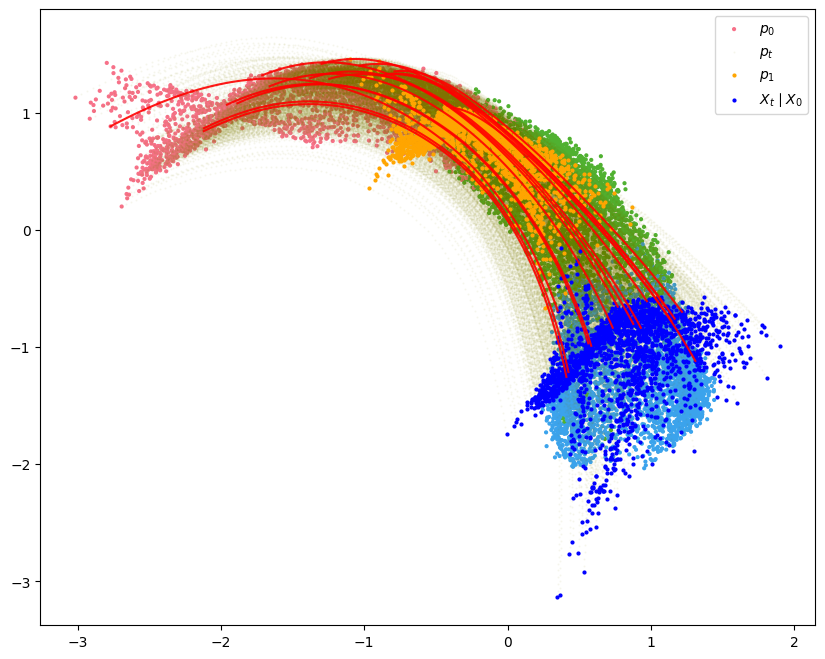

In [26]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)
        v0 = torch.from_numpy(v_train[t]).float().to(device)
        v1 = torch.from_numpy(v_train[t + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(vel_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        out = node.trajectory(
            z0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        traj_tmp = out[:, :, :-2]

        trajs.append(traj_tmp)

    traj_curly = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1, cos_dist, L2_cost = [], [], []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)
        v0 = torch.from_numpy(velocities[t_train]).float().to(device)
        v1 = torch.from_numpy(velocities[t_train + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(vel_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        pred_out = node.trajectory(
            z0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred_traj = pred_out[:, :, :-2]
        cosine_traj = pred_out[:, :, -2]
        L2_traj = pred_out[:, :, -1]

        pred = pred_traj[-1]

        cos_dist.append(cosine_traj[-1].cpu().mean())
        L2_cost.append(L2_traj[-1].cpu().mean())

        print(L2_traj[-1].cpu().mean())

        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    cos_dist = np.stack(cos_dist)
    L2_cost = np.stack(L2_cost)

    print("Avg Cosine distance: ", np.mean(cos_dist))
    print("Avg L2 cost: ", np.mean(L2_cost))

    wass1 = np.stack(wass1)
    print("Avg Wass-2 distance: ", np.mean(wass1))

    print()
    print("----------------------")
    print()
    print("t            Cosine-dist    &      L2 cost       &       Wass-2 ")
    for i, t_left_out in enumerate(["t2"]):
        print(t_left_out + f" --- {cos_dist[i]} & {L2_cost[i]} & {wass1[i]} \\\\")

    train_time_curly = train_time_curly_geo + train_time_curly_vel
    minutes = int(train_time_curly // 60)
    seconds = int(train_time_curly % 60)

    print()
    print(f"Curly training time -- {minutes}:{seconds} (mins:secs)")

    plot_trajectories(
        traj_curly.cpu().numpy()
    )
